In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader as ShapeReader, natural_earth
from glob import glob
import netCDF4 as nc
from matplotlib import cm
from datetime import datetime
import cartopy.io.img_tiles as cimgt
from cartopy.io.shapereader import Reader

import matplotlib as mpl
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 25}
mpl.rc('font', **font)
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('hourly/stations-2020.05.08.csv')
df = df.replace('-', np.nan)
ids = np.where( df['纬度'].values != df['纬度'].values) [0]
subdf = df.drop(ids, axis=0)
lats = subdf['纬度'].astype(float).tolist()
lons = subdf['经度'].astype(float).tolist()

ids = subdf['监测点编码'].astype(str).tolist()


latdic = dict(zip(ids, lats))
londic = dict(zip(ids, lons))

In [3]:
flist = glob('hourly/*.txt')

fnow = flist[0]
datenow = 20140513
print(fnow, datenow)
df = pd.read_csv(fnow)

subdf = df.loc[df['Date'] == datenow]

hourly\20140513-20141231 hour NO2(station).txt 20140513


In [4]:
dic = subdf.groupby('Station')['NO2'].apply(list).to_dict()

In [5]:
# Download the Natural Earth shapefile for country boundaries at 10m resolution
shapefile = natural_earth(category='cultural',
                          resolution='10m',
                          name='admin_1_states_provinces')

country_borders = cfeature.NaturalEarthFeature(
    category='cultural',
    name='‘admin_0_boundary_lines_land',
    scale='10m',
    facecolor='none')

# Sort the geometries in the shapefile into Chinese/Taiwanese or other
country_geos = []
other_land_geos = []
for record in ShapeReader(shapefile).records():
    if record.attributes['admin'] in ['China', 'Taiwan']:
        country_geos.append(record.geometry)
    else:
        other_land_geos.append(record.geometry)
        
# Extract the Chinese province borders
province_geos = [
    record.geometry
    for record in ShapeReader(shapefile).records()
    if record.attributes['admin'] == 'China'
]

projection=ccrs.PlateCarree()
# Define a Cartopy Feature for the province borders, so they can be easily plotted
provinces = ShapelyFeature(province_geos,
                           crs=projection,
                           facecolor='none',
                           edgecolor='black',
                           lw=0.25)

### In situ map

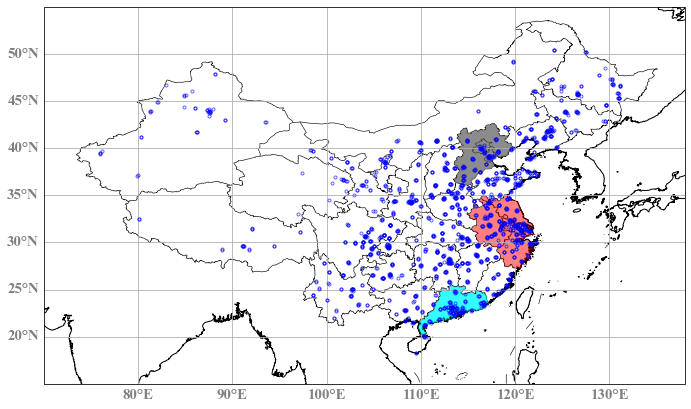

In [7]:
fig = plt.figure(figsize=(10, 6)) # open matplotlib figure
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.coastlines(resolution='10m')
plt.rc('font', family='Times New Roman')

# ax.add_feature(cfeature.LAKES, alpha=0.5)
# ax.add_feature(cfeature.RIVERS, alpha=0.5)
# stamen_terrain = cimgt.Stamen('terrain-background')



shp_path='制作中国地图/bou2_4l.shp'
reader = Reader(shp_path)
chinamap = cfeature.ShapelyFeature(reader.geometries(), ccrs.PlateCarree(), edgecolor='k', facecolor='none')
ax.add_feature(chinamap, linewidth=0.6)
ax.set_extent([72, 138, 15, 50])
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=0.5,color='grey', alpha=0.3, linestyle='--')

# #Plot South China Sea as a subfigure
# sub_ax = fig.add_axes([0.82, -0.01, 0.14, 0.5],
#                       projection=ccrs.LambertConformal(central_latitude=90,
#                                                        central_longitude=115))
# # Add ocean, land, rivers and lakes
# sub_ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.4, zorder=1)
# with open('CN-border-La.dat') as src:
#     context = src.read()
#     blocks = [cnt for cnt in context.split('>') if len(cnt) > 0]
#     borders = [np.fromstring(block, dtype=float, sep=' ') for block in blocks]
# # Plot border lines
# for line in borders:
#     sub_ax.plot(line[0::2], line[1::2], '-', lw=0.5, color='k',
#                 transform=ccrs.Geodetic())
# # Set figure extent
# sub_ax.set_extent([105, 125, 0, 25],crs=ccrs.PlateCarree())
# ax.add_image(stamen_terrain, 8)
# sub_ax.add_image(stamen_terrain, 8)

shp_path='制作中国地图/中国政区.shp'
reader = Reader(shp_path)
for country in reader.records():
    name = country.attributes['NAME']
    if name in ['北京市', '天津市', '河北省']:
        ax.add_geometries([country.geometry], ccrs.PlateCarree(),
                facecolor='gray', edgecolor='k', linewidth=0.2, alpha=0.9)
#         sub_ax.add_geometries([country.geometry], ccrs.PlateCarree(),
#                 facecolor='gray', edgecolor='k', linewidth=0.5, alpha=0.5)
    if name in ['上海市', '江苏省', '浙江省', '安徽省']:
        ax.add_geometries([country.geometry], ccrs.PlateCarree(),
                facecolor='red', edgecolor='k', linewidth=0.2, alpha=0.5)
#         sub_ax.add_geometries([country.geometry], ccrs.PlateCarree(),
#                 facecolor='red', edgecolor='k', linewidth=0.5, alpha=0.5)
    if name in ['广东省']:
        ax.add_geometries([country.geometry], ccrs.PlateCarree(),
                facecolor='cyan', edgecolor='k', linewidth=0.2, alpha=0.8)
#         sub_ax.add_geometries([country.geometry], ccrs.PlateCarree(),
#                 facecolor='yellow', edgecolor='k', linewidth=0.5, alpha=0.5)

        
ax.plot(lons, lats, markersize=3, marker='o',linestyle='', markerfacecolor='none', markeredgecolor='blue', 
        transform=ccrs.PlateCarree(), alpha=0.6)
# sub_ax.plot(lons, lats, markersize=3, marker='o',linestyle='', markerfacecolor='none', markeredgecolor='blue', 
#         transform=ccrs.PlateCarree(), alpha=0.6)
ax.set_extent([70, 138, 15, 50])

gl = ax.gridlines(draw_labels=True)
# plt.title('Location of in situ stations', y=1.1)
gl.xlabel_style = {'size': 15, 'color': 'gray'}
gl.ylabel_style = {'size': 15, 'color': 'gray'}
gl.xlabels_top = False  # 关闭顶端的经纬度标签
gl.ylabels_right = False  # 关闭右侧的经纬度标签

plt.subplots_adjust(left=0.08, right=0.97, bottom=0.05, top=0.97)
plt.savefig('insitu_map.pdf', dpi=300)

In [60]:
fh = nc.Dataset('nox_2019_t106_China.nc')
latslr = fh.variables['lat'][:]
lonslr = fh.variables['lon'][:]
fh.close()

fh = nc.Dataset('nox_2019_t213_China.nc')
latshr = fh.variables['lat'][:]
lonshr = fh.variables['lon'][:]
fh.close()

hrmask = np.zeros((len(latshr), len(lonshr)))
lrmask = np.zeros((len(latslr), len(lonslr)))


print(len(lats), len(lons), len(latdic.keys()))
for i in range(len(latdic.keys())):
    snow = list(latdic.keys())[i]
    latnow = latdic[snow]
    lonnow = londic[snow]
    
    ihr = np.argmin(abs(latnow - latshr))
    jhr = np.argmin(abs(lonnow - lonshr))
    
    ilr = np.argmin(abs(latnow - latslr))
    jlr = np.argmin(abs(lonnow - lonslr))
    
    hrmask[ihr, jhr] += 1
    lrmask[ilr, jlr] += 1
    
np.save('HR_mask.npy', hrmask)
np.save('LR_mask.npy', lrmask)

1652 1652 1651


In [214]:
def gen_bound(lat):
    lats_b = list( (lat[1:] + lat[:-1])/2 )
    left = [  lat[0] - (lat[1] - lat[0])/2   ]
    right = [  lat[-1] + (lat[-1] - lat[-2])/2   ]
    
    return np.array( left + lats_b + right)

In [216]:
lonslr_b = gen_bound(lonslr)
latslr_b = gen_bound(latslr)



lonshr_b = gen_bound(lonshr)
latshr_b = gen_bound(latshr)


print(lonslr.shape, lonslr_b.shape)

print(latslr.shape, latslr_b.shape)


(46,) (47,)
(35,) (36,)


In [234]:
hrmask[hrmask == 0] = np.nan
lrmask[lrmask == 0] = np.nan
cmap = plt.get_cmap('jet', 9)
cmap.set_under(color = 'white')

### Station density

C:\Users\tailong\Anaconda3\envs\tf3\lib\site-packages\matplotlib\font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


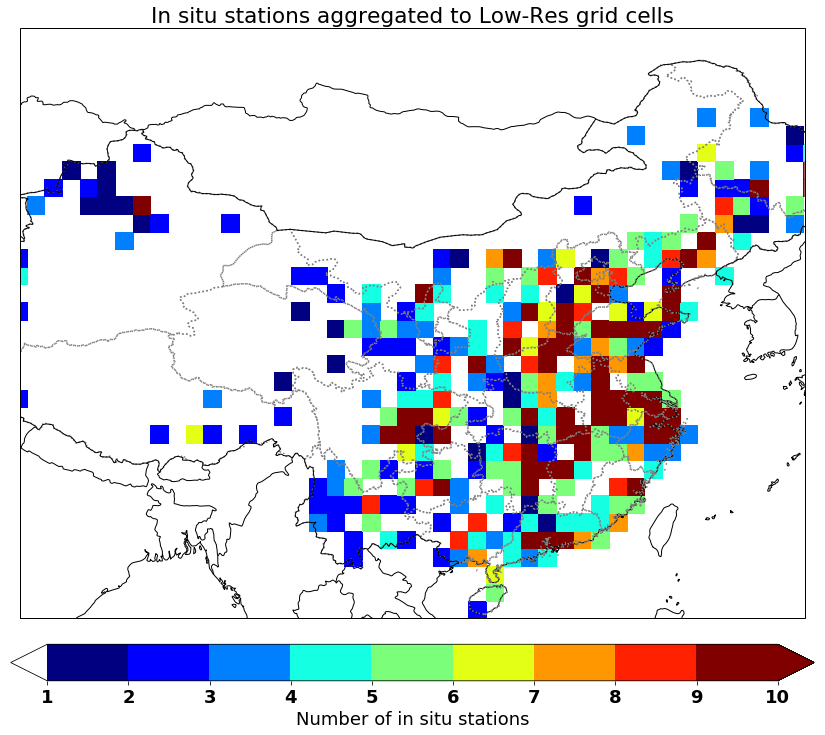

In [235]:
fig = plt.figure(figsize=(15, 12)) # open matplotlib figure
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.coastlines(resolution='50m')

ax.add_feature(provinces, linestyle=':', edgecolor='gray', lw=1.5)
ax.add_feature(country_borders, edgecolor='black')

im = ax.pcolormesh(lonslr_b, latslr_b, lrmask, transform=ccrs.PlateCarree(), cmap=cmap, vmin=1, vmax=10)
cbar = plt.colorbar(im, orientation='horizontal', pad=0.04, fraction=0.056, extend='both')
cbar.set_label('Number of in situ stations')
ax.set_extent([80, 130, 18, 53 ])
plt.title('In situ stations aggregated to Low-Res grid cells')

plt.savefig('low_res_density.png', dpi=400)

C:\Users\tailong\Anaconda3\envs\tf3\lib\site-packages\matplotlib\font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


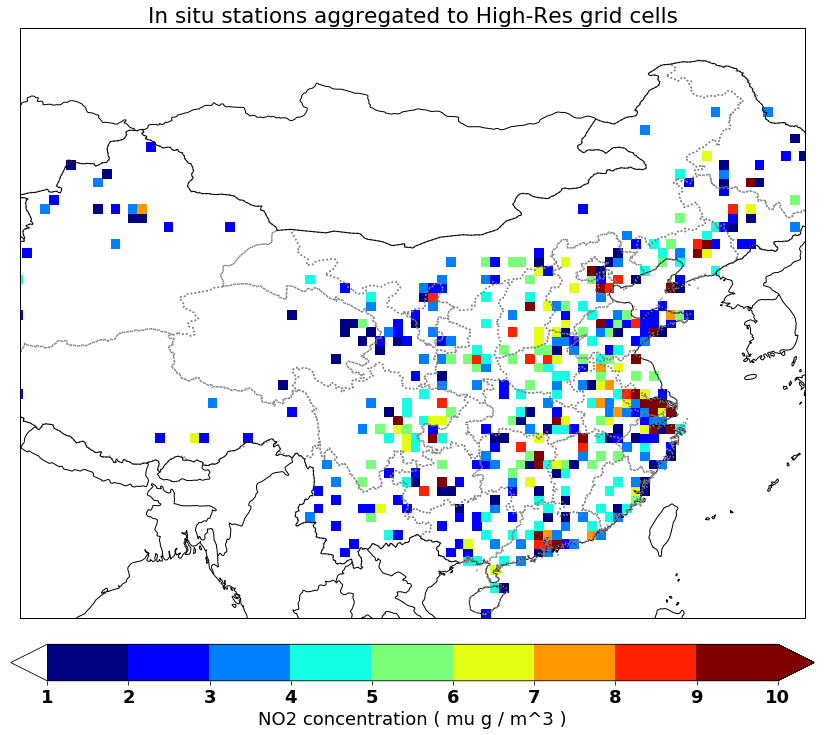

In [236]:
fig = plt.figure(figsize=(15, 12)) # open matplotlib figure
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.coastlines(resolution='50m')

ax.add_feature(provinces, linestyle=':', edgecolor='gray', lw=1.5)
ax.add_feature(country_borders, edgecolor='black')

im = ax.pcolor(lonshr_b, latshr_b, hrmask, transform=ccrs.PlateCarree(), cmap=cmap, vmin=1, vmax=10)
cbar = plt.colorbar(im, orientation='horizontal', pad=0.04, fraction=0.056, extend='both')
cbar.set_label('NO2 concentration ( mu g / m^3 )')
ax.set_extent([80, 130, 18, 53 ])

plt.title('In situ stations aggregated to High-Res grid cells')

plt.savefig('high_res_density.png', dpi=400)

### NO2 comparison with In situ

In [2]:
fh = nc.Dataset('no2_2019_t106_China.nc')
lon =  fh.variables['lon'][:]
lat = fh.variables['lat'][:]
tcrlr = fh.variables['no2'][:]/1e3
fh.close()


# fh = nc.Dataset('no2_2019_t213_China.nc')
# lonhr =  fh.variables['lon'][:]
# lathr = fh.variables['lat'][:]
# tcrhr = fh.variables['no2'][:]/1e3
# fh.close()

C:\Users\tailong\Anaconda3\envs\tf3\lib\site-packages\matplotlib\font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


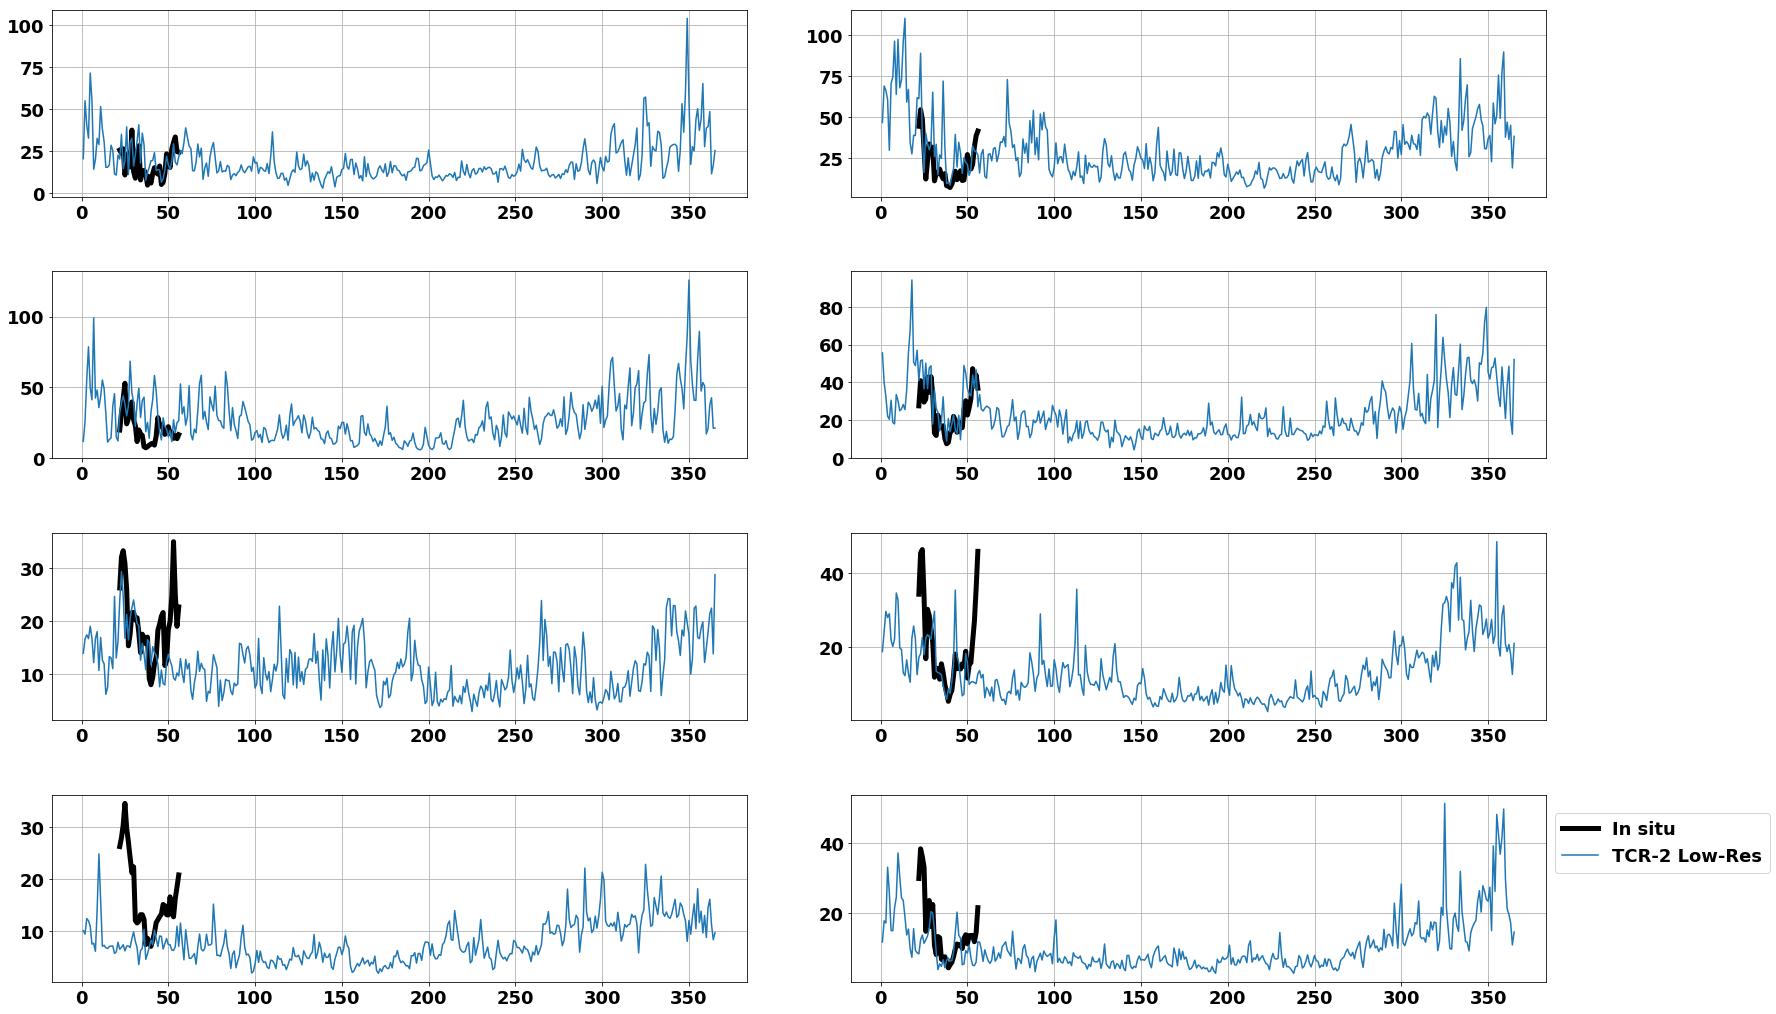

In [10]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 18}
mpl.rc('font', **font)

df = pd.read_table('China_obs.txt', delimiter=',')
df = df[df['Date'].str.contains("2019")]


cities = [ 'beijing', 'shanghai', 'guangzhou', 'shijiazhuang', 'chengdu', 
          'hefei', 'zhuzhou', 'nanchang' ]

plt.figure(figsize=(25, 15))
curr = 1
for cc in cities:
    subnow = df.loc[ df['Station'] == cc ]

    time  = subnow['Date'].values

    time = np.array([datetime.strptime(s, '%Y-%m-%d') for s in time])

    doy = np.array([s.timetuple().tm_yday for s in time])

    lonnow = subnow['Lon'].values[0]
    latnow = subnow['Lat'].values[0]

    ix = np.argmin( abs(lonnow - lon) )
    iy = np.argmin( abs(latnow - lat) )
    lrnow = tcrlr[:, iy, ix]

    ix = np.argmin( abs(lonnow - lonhr) )
    iy = np.argmin( abs(latnow - lathr) )
    hrnow = tcrhr[:, iy, ix]
    
    
    insitu = subnow['NO2'].values / 1.91 # convert to ppb

    

    ax = plt.subplot(4, 2, curr)
    ax.plot(doy, insitu, 'k-', lw=5, label='In situ')
    
    xx = np.arange(1, 366, 1)
    ax.plot(xx, lrnow, label='TCR-2 Low-Res')
    ax.grid()
    
#     xx = np.arange(15, 15+107, 1)
#     ax.plot(xx, hrnow[:-30], label='TCR-2 High-Res')
#     ax.grid()
#     plt.ylabel('Surf NO2 (ppb)')
#     plt.xlabel('Day of year')
#     plt.title(cc)
    
    curr += 1
    

plt.subplots_adjust(left=0.05, wspace=0.15, hspace=0.4, right=0.88, top=0.95, bottom=0.05)
ax.legend(bbox_to_anchor=(1.00, 0.95))
plt.savefig('NO2_station_comp.png', dpi=400)

### NOx comparison with EDGAR in 2015

### NO2 plots

(35, 46)
[17.383 18.505 19.626 20.748 21.869 22.991 24.112 25.234 26.355 27.476
 28.598 29.719 30.841 31.962 33.084 34.205 35.327 36.448 37.57  38.691
 39.813 40.934 42.056 43.177 44.299 45.42  46.542 47.663 48.785 49.906
 51.028 52.149 53.271 54.392 55.514]


C:\Users\tailong\Anaconda3\envs\tf3\lib\site-packages\matplotlib\font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


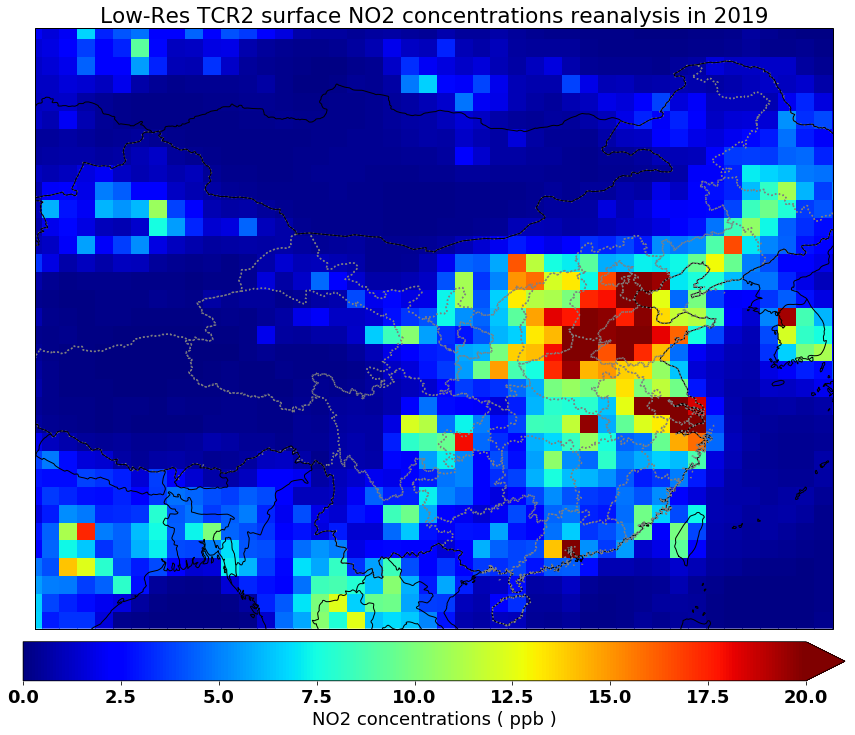

In [227]:
fh = nc.Dataset('no2_2019_t106_China.nc')
latslr = fh.variables['lat'][:]
lonslr = fh.variables['lon'][:]
nox = fh.variables['no2'][14:14+137]
fh.close()


nox = np.mean(nox, axis=0)/1e3


print(nox.shape)

fig = plt.figure(figsize=(15, 12)) # open matplotlib figure
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.coastlines(resolution='50m')

ax.add_feature(provinces, linestyle=':', edgecolor='gray', lw=1.5)
ax.add_feature(country_borders, edgecolor='black')

print(latslr)
im = ax.pcolormesh(lonslr_b, latslr_b, nox, transform=ccrs.PlateCarree(), cmap=cm.jet, vmin=0, vmax=20)
cbar = plt.colorbar(im, orientation='horizontal', pad=0.02, fraction=0.06, extend='max')
cbar.set_label('NO2 concentrations ( ppb )')
ax.set_extent([80, 130, 18, 53 ])

plt.title('Low-Res TCR2 surface NO2 concentrations reanalysis in 2019')

plt.savefig('t106_no2.png', dpi=400)

C:\Users\tailong\Anaconda3\envs\tf3\lib\site-packages\matplotlib\font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


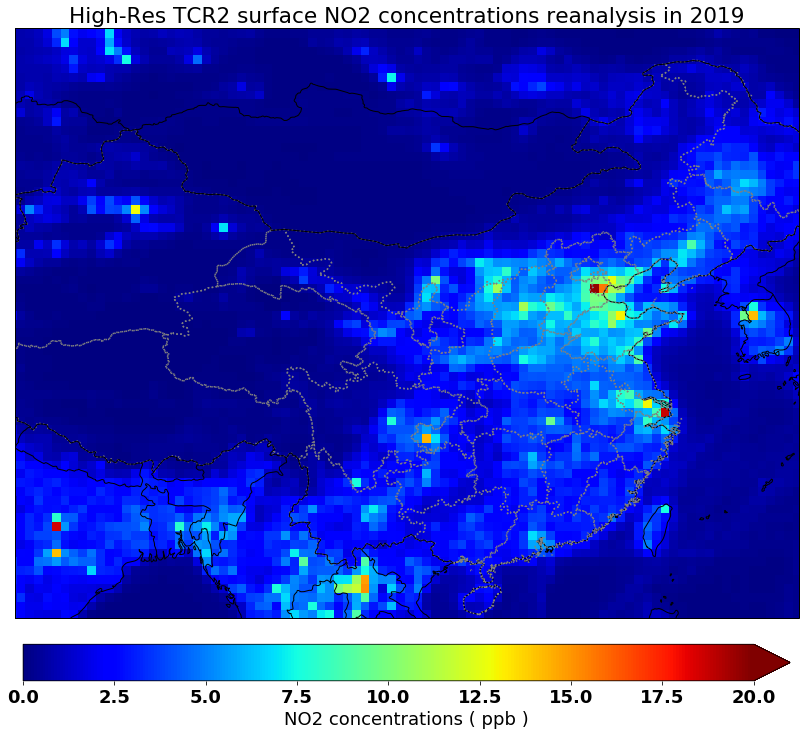

In [228]:
fh = nc.Dataset('no2_2019_t213_China.nc')
latshr = fh.variables['lat'][:]
lonshr = fh.variables['lon'][:]
nox = fh.variables['no2'][:]
fh.close()


nox = np.mean(nox, axis=0)/1e3

fig = plt.figure(figsize=(15, 12)) # open matplotlib figure
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.coastlines(resolution='50m')

ax.add_feature(provinces, linestyle=':', edgecolor='gray', lw=1.5)
ax.add_feature(country_borders, edgecolor='black')

im = ax.pcolor(lonshr_b, latshr_b, nox, transform=ccrs.PlateCarree(), cmap=cm.jet, vmin=0, vmax=20)
cbar = plt.colorbar(im, orientation='horizontal', pad=0.04, fraction=0.056, extend='max')

cbar.set_label('NO2 concentrations ( ppb )')
ax.set_extent([80, 130, 18, 53 ])

plt.title('High-Res TCR2 surface NO2 concentrations reanalysis in 2019')

plt.savefig('t213_no2.png', dpi=400)

### NOx plots

C:\Users\tailong\Anaconda3\envs\tf3\lib\site-packages\matplotlib\font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


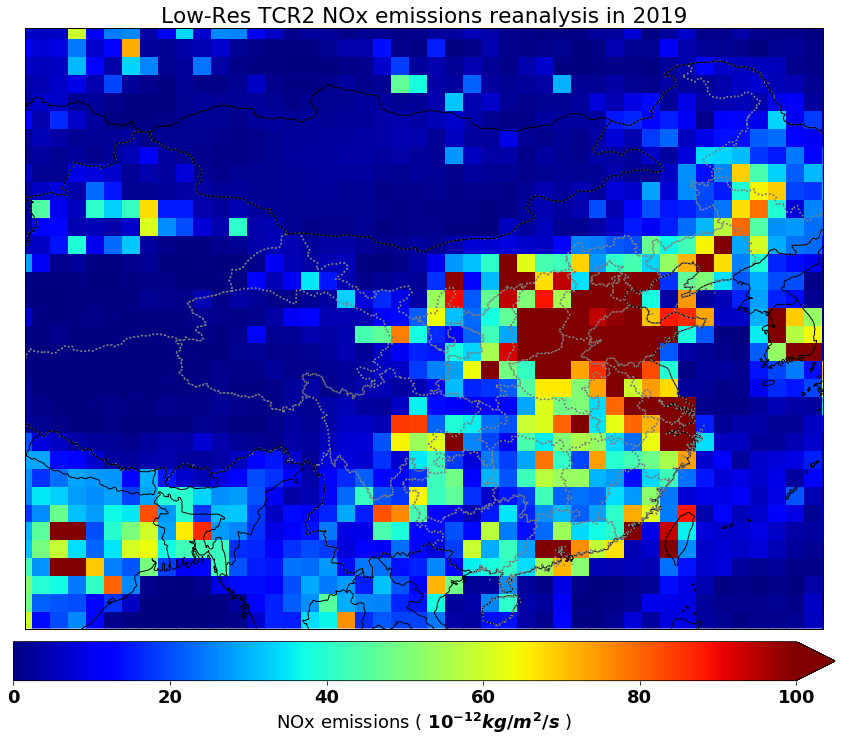

In [231]:
fh = nc.Dataset('nox_2019_t106_China.nc')
latslr = fh.variables['lat'][:]
lonslr = fh.variables['lon'][:]
nox = fh.variables['nox'][:]
fh.close()


# /0.046*6.02214086e23*0.0001
nox = np.mean(nox, axis=0)*1e12


fig = plt.figure(figsize=(15, 12)) # open matplotlib figure
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.coastlines(resolution='50m')

ax.add_feature(provinces, linestyle=':', edgecolor='gray', lw=1.5)
ax.add_feature(country_borders, edgecolor='black')

im = ax.pcolormesh(lonslr_b, latslr_b, nox, transform=ccrs.PlateCarree(), cmap=cm.jet, vmin=0, vmax=100)
cbar = plt.colorbar(im, orientation='horizontal', pad=0.02, fraction=0.06, extend='max')
cbar.set_label('NOx emissions ( $10^{-12} kg/m^{2}/s$ )')
ax.set_extent([80, 130, 18, 53 ])

plt.title('Low-Res TCR2 NOx emissions reanalysis in 2019')

plt.savefig('t106_nox.png', dpi=400)

(68, 91)


C:\Users\tailong\Anaconda3\envs\tf3\lib\site-packages\matplotlib\font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


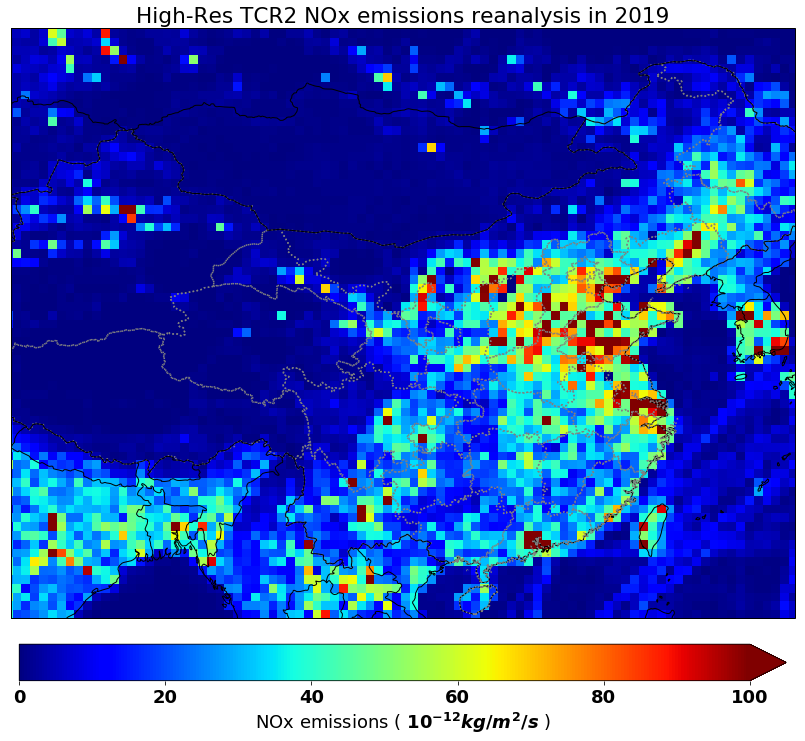

In [226]:
fh = nc.Dataset('nox_2019_t213_China.nc')
latshr = fh.variables['lat'][:]
lonshr = fh.variables['lon'][:]
nox = fh.variables['nox'][:]
fh.close()


nox = np.mean(nox, axis=0)*1e12

print(nox.shape)

fig = plt.figure(figsize=(15, 12)) # open matplotlib figure
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.coastlines(resolution='50m')

ax.add_feature(provinces, linestyle=':', edgecolor='gray', lw=1.5)
ax.add_feature(country_borders, edgecolor='black')

im = ax.pcolor(lonshr_b, latshr_b, nox, transform=ccrs.PlateCarree(), cmap=cm.jet, vmin=0, vmax=100)
cbar = plt.colorbar(im, orientation='horizontal', pad=0.04, fraction=0.056, extend='max')

cbar.set_label('NOx emissions ( $10^{-12} kg/m^{2}/s$ )')
ax.set_extent([80, 130, 18, 53 ])

plt.title('High-Res TCR2 NOx emissions reanalysis in 2019')

plt.savefig('t213_nox.png', dpi=400)

C:\Users\tailong\Anaconda3\envs\tf3\lib\site-packages\matplotlib\font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


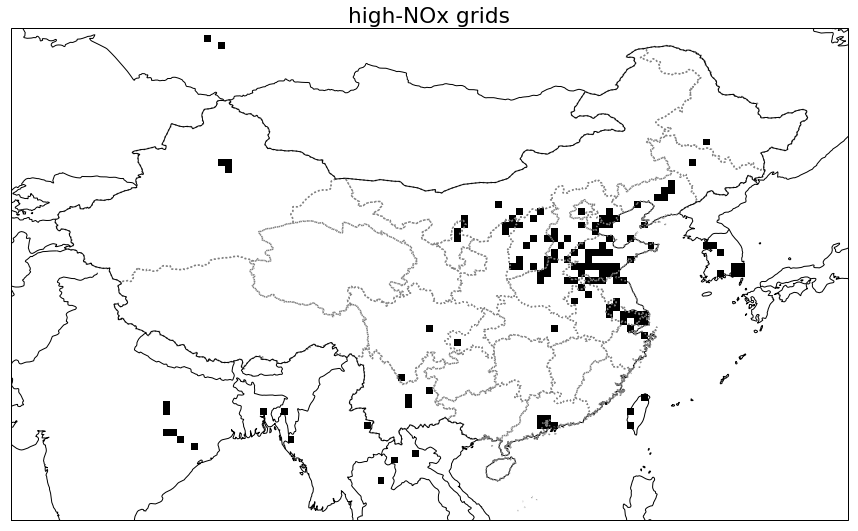

In [230]:
fh = nc.Dataset('nox_2019_t213_China.nc')
latshr = fh.variables['lat'][:]
lonshr = fh.variables['lon'][:]
nox = fh.variables['nox'][:]
fh.close()


nox = np.mean(nox, axis=0)/0.046*6.02214086e23*0.0001


fig = plt.figure(figsize=(15, 12)) # open matplotlib figure
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.coastlines(resolution='50m')

ax.add_feature(provinces, linestyle=':', edgecolor='gray', lw=1.5)
ax.add_feature(country_borders, edgecolor='black')

im = ax.pcolor(lonshr_b, latshr_b, nox > 1e11, transform=ccrs.PlateCarree(), cmap=cm.binary)
# plt.colorbar(im, orientation='horizontal', pad=0.02)
ax.set_extent([70, 138, 15, 50])

mask = np.zeros((nox.shape))
mask[np.where(nox > 1e11)] = 1


np.save('China_urban_grids.npy', mask)

plt.title('high-NOx grids')

plt.savefig('China_urban_grids.pdf')